In [5]:
import dask.dataframe as dd
import dask.multiprocessing
import dask
import numpy as np
from dask import delayed
import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
import cv2
from glob import glob
import json
import dask.array as da
import time
import xgboost as xgb
import pandas as pd
import os
from dask import compute

@delayed
def padding(data, array_len, col_len):
    pad = np.zeros((array_len, col_len))
    length = min(array_len, len(data))
    
    pad[:length] = data[:length]
    return pad

@delayed
def img_resize(img):
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)/255
    return img

path = os.getcwd()
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(cluster,client)
# client.close()
# http://localhost:8787/status



LocalCluster(8ab41659, 'tcp://127.0.0.1:43833', workers=4, threads=16, memory=24.59 GiB) <Client: 'tcp://127.0.0.1:43833' processes=4 threads=16, memory=24.59 GiB>


distributed.diskutils - INFO - Found stale lock file and directory '/home/gob/repos/Dacon_tabular_img_classification_model/dask-worker-space/worker-wki7cejq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gob/repos/Dacon_tabular_img_classification_model/dask-worker-space/worker-z873ldy0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gob/repos/Dacon_tabular_img_classification_model/dask-worker-space/worker-9nmduuar', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gob/repos/Dacon_tabular_img_classification_model/dask-worker-space/worker-ztto_eaz', purging


In [6]:
print(cluster,client)

LocalCluster(8ab41659, 'tcp://127.0.0.1:43833', workers=4, threads=16, memory=24.59 GiB) <Client: 'tcp://127.0.0.1:43833' processes=4 threads=16, memory=24.59 GiB>


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7010511161112348162
xla_global_id: -1
]


2022-01-21 12:46:05.052062: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-21 12:46:05.298242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-21 12:46:05.335539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gob/anaconda3/envs/dacon_parm_01/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda-11.6/lib64:/usr/local/cuda-11.6/lib64:
2022-01-21 12:46:05.335559: W tensorflow/core/common_ru

In [8]:
#making_label_set
# 
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}


#ensemble_labler
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'

global ensemble_label_encoder
ensemble_label_encoder = {key:idx for idx, key in enumerate(label_description)}
ensemble_label_decoder = {val:key for key, val in ensemble_label_encoder.items()}

#crop_labler
crop_label_description = {}
for key, value in disease.items():
    crop_label_description[f'{key}'] = f'{crop[key]}'
    
global crop_label_encoder
crop_label_encoder = {key:idx for idx, key in enumerate(crop_label_description)}
crop_label_decoder = {val:key for key, val in crop_label_encoder.items()}


#disease_labler
disease_label_description = {}
for key, value in disease.items():
    disease_label_description[f'00'] = f'{crop[key]}'
    for disease_code in value:
        label = f'{disease_code}'
        disease_label_description[label] = f'{disease_code}'

global disease_label_encoder
disease_label_encoder = {key:idx for idx, key in enumerate(disease_label_description)}
disease_label_decoder = {val:key for key, val in disease_label_encoder.items()}


#risk_labler
risk_label_description = {}
for key, value in risk.items():
    label = f'{key}'
    risk_label_description[label] = f'{key}'

global risk_label_encoder
risk_label_encoder = {key:idx for idx, key in enumerate(risk_label_description)}
risk_label_decoder = {val:key for key, val in risk_label_encoder.items()}





In [9]:
@delayed
def label_encoding(label):
    global label_encoder
    encoded_label = ensemble_label_encoder[label]
    return encoded_label

def getlable(jsonpath):
    with open(jsonpath, 'r') as f:
        json_file = json.load(f)

    crop = json_file['annotations']['crop']
    disease = json_file['annotations']['disease']
    risk = json_file['annotations']['risk']
    label = f'{crop}_{disease}_{risk}'
    return label
    
def get_label_list(labelpath_list):
    labelarr = np.array([])
    # labelarr = da.array([])
    for ind,json_path in enumerate(labelpath_list):
        # label = label_encoding(getlable(json_path))
        # label = da.array(np.array(label_encoding(getlable(json_path))))
        label = np.array(label_encoding(getlable(json_path)))
        labelarr = np.append(labelarr,label)
    return labelarr

In [10]:
@delayed
def get_all_image(imgpath_list,image_size):
    imgarr = np.empty((0,image_size,image_size,3), float)
    for ind,img_path in enumerate(imgpath_list):
        imgarr = delayed(np.append)(imgarr,img, axis = 0)
    return imgarr

In [10]:
#making_img_set
row_img = dask_image.imread.imread(path+"/train/*/*.jpg")
# row_img = row_img.rechunk(1000)

In [11]:
from tensorflow.keras.applications.resnet import ResNet50
model_RESNET50 = ResNet50(weights='imagenet')

In [12]:
row_img

,Array,Chunk
Bytes,3.17 GiB,576.00 kiB
Shape,"(5767, 512, 384, 3)","(1, 512, 384, 3)"
Count,17301 Tasks,5767 Chunks
Type,uint8,numpy.ndarray


In [13]:
@delayed
def imageresize(img):
    # img = dask.delayed(cv2.resize)(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    # img = dask.delayed(img.astype(np.float32)/255)  ##픽셀값을 0~1사이로 정규화
    # # img = np.transpose(img, (2,0,1))
    # return dask.delayed(img.reshape)(-1,224,224,3)
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)/255  ##픽셀값을 0~1사이로 정규화
    # img = np.transpose(img, (2,0,1))
    return img

In [14]:
test = [imageresize(img) for img in row_img]


In [15]:
minibatch_size = 200
data_length = len(test)
loop_num = int(np.floor(data_length/minibatch_size))
train_x = np.zeros((data_length,1000))

count = 0
for i in range(loop_num):
    print(i)
    if i != loop_num-1:
        start_p = count*minibatch_size
        end_p = (count+1)*minibatch_size
        train_x[start_p:end_p] = model_RESNET50(np.array(compute(test[start_p:end_p])[0]))
        
    else:
        start_p = count*minibatch_size
        end_p = (count+1)*minibatch_size
        train_x[start_p:] = model_RESNET50(np.array(compute(test[start_p:])[0]))
            
    count += 1
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [16]:
train_x.shape

(5767, 1000)

In [17]:
label_list = sorted(glob(path+"/train/*/*.json"))
y_train = get_label_list(label_list)
# y_train = y_train.rechunk(5767)
results = dask.compute(*y_train)
label = np.array(results)
# print(label.shape)

In [18]:
params = {"tree_method": "gpu_hist", 
          "objective": 'multi:softmax',
          "subsample": 0.8,
          "colsample_bytree": 0.8,
        #   "single_precision_histogram" : True,
          }


start = time.time()
xgb_model = xgb.XGBClassifier(params,eval_metric='mlogloss',).fit(train_x,label)
print(time.time()-start)

/home/gob/anaconda3/envs/dacon_parm_01/lib/python3.7/site-packages/xgboost/core.py:502: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning
/home/gob/anaconda3/envs/dacon_parm_01/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


98.46835899353027


예측

In [11]:
#making_img_set
test_row_img = dask_image.imread.imread(path+"/test/*/*.jpg")
# test_row_img = test_row_img.rechunk(1000)



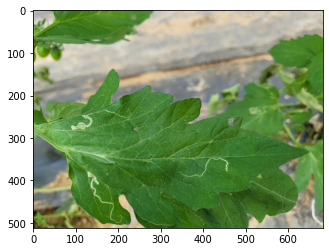

In [19]:
import matplotlib.pyplot as plt
plt.imshow(test_row_img[-2])

In [16]:
test_row_img[0]

dask.array<getitem, shape=(512, 682, 3), dtype=uint8, chunksize=(512, 682, 3), chunktype=numpy.ndarray>

In [20]:
batch = [imageresize(img) for img in test_row_img[:]]
print("ok")
minibatch_size = 100
data_length = len(batch)
loop_num = int(np.floor(data_length/minibatch_size))
# input_x = np.zeros((data_length,1000))
input_x = dask.array.zeros((data_length,1000))

count = 0
for i in range(loop_num):
    print(i)
    if i != loop_num-1:
        start_p = count*minibatch_size
        end_p = (count+1)*minibatch_size
        print("01010")
        input_x[start_p:end_p] = model_RESNET50(np.array(compute(batch[start_p:end_p])[0])).numpy()
        
    else:
        start_p = count*minibatch_size
        end_p = (count+1)*minibatch_size
        print("here")
        input_x[start_p:] = model_RESNET50(np.array(compute(batch[start_p:])[0])).numpy()
        print("here")
    count += 1
    print("here")

out = xgb_model.predict(input_x)


ok
0
01010
here
1
01010
here
2
01010
here
3
01010
here
4
01010
here
5
01010
here
6
01010
here
7
01010
here
8
01010
here
9
01010
here
10
01010
here
11
01010
here
12
01010
here
13
01010
here
14
01010
here
15
01010
here
16
01010
here
17
01010
here
18
01010
here
19
01010
here
20
01010
here
21
01010
here
22
01010
here
23
01010
here
24
01010
here
25
01010
here
26
01010
here
27
01010
here
28
01010
here
29
01010
here
30
01010
here
31
01010
here
32
01010
here
33
01010
here
34
01010
here
35
01010
here
36
01010
here
37
01010
here
38
01010
here
39
01010
here
40
01010
here
41
01010
here
42
01010
here
43
01010
here
44
01010
here
45
01010
here
46
01010
here
47
01010
here
48
01010
here
49
01010
here
50
01010
here
51
01010
here
52
01010
here
53
01010
here
54
01010
here
55
01010
here
56
01010
here
57
01010
here
58
01010
here
59
01010
here
60
01010
here
61
01010
here
62
01010
here
63
01010
here
64
01010
here
65
01010
here
66
01010
here
67
01010
here
68
01010
here
69
01010
here
70
01010
here
71
01010
here

In [ ]:
submission = pd.read_csv(path+"/sample_submission.csv")
submission.loc[:,'label'] = np.array([ensemble_label_decoder[int(val)] for val in out])
submission.to_csv(path+'/submissions/gogo_submission_05.csv', index=False)